In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import skew, kurtosis


%matplotlib inline

In [2]:
df_final_demo = pd.read_csv('df_final_demo.txt')
df_final_experiment_clients = pd.read_csv('df_final_experiment_clients.txt')
df_pt_1 = pd.read_csv('df_pt_1.txt')
df_pt_2 = pd.read_csv('df_pt_2.txt')

In [3]:
df_final_demo

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...,...
70604,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0


In [4]:
df_final_experiment_clients

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


In [5]:
df_pt_1

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
343136,2443347,465784886_73090545671,136329900_10529659391_316129,confirm,2017-03-31 15:15:46
343137,2443347,465784886_73090545671,136329900_10529659391_316129,step_3,2017-03-31 15:14:53
343138,2443347,465784886_73090545671,136329900_10529659391_316129,step_2,2017-03-31 15:12:08
343139,2443347,465784886_73090545671,136329900_10529659391_316129,step_1,2017-03-31 15:11:37


In [6]:
df_pt_2

,client_id,visitor_id,visit_id,process_step,date_time
0,763412,601952081_10457207388,397475557_40440946728_419634,confirm,2017-06-06 08:56:00
1,6019349,442094451_91531546617,154620534_35331068705_522317,confirm,2017-06-01 11:59:27
2,6019349,442094451_91531546617,154620534_35331068705_522317,step_3,2017-06-01 11:58:48
3,6019349,442094451_91531546617,154620534_35331068705_522317,step_2,2017-06-01 11:58:08
4,6019349,442094451_91531546617,154620534_35331068705_522317,step_1,2017-06-01 11:57:58
...,...,...,...,...,...
412259,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
412260,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
412261,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
412262,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


- Unir las dos partes de pt.

In [7]:
df_pt = pd.concat([df_pt_1, df_pt_2], ignore_index=True)

In [8]:
df_pt

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


- Descripción general de los df.

In [9]:
df_final_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         70609 non-null  int64  
 1   clnt_tenure_yr    70595 non-null  float64
 2   clnt_tenure_mnth  70595 non-null  float64
 3   clnt_age          70594 non-null  float64
 4   gendr             70595 non-null  object 
 5   num_accts         70595 non-null  float64
 6   bal               70595 non-null  float64
 7   calls_6_mnth      70595 non-null  float64
 8   logons_6_mnth     70595 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.8+ MB


In [10]:
df_final_experiment_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  70609 non-null  int64 
 1   Variation  50500 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [11]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755405 entries, 0 to 755404
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     755405 non-null  int64 
 1   visitor_id    755405 non-null  object
 2   visit_id      755405 non-null  object
 3   process_step  755405 non-null  object
 4   date_time     755405 non-null  object
dtypes: int64(1), object(4)
memory usage: 28.8+ MB


In [12]:
df_final_demo.describe()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,num_accts,bal,calls_6_mnth,logons_6_mnth
count,7.060900e+04,70595.000000,70595.000000,70594.000000,70595.000000,7.059500e+04,70595.000000,70595.000000
mean,5.004992e+06,12.052950,150.659367,46.442240,2.255528,1.474452e+05,3.382478,5.566740
std,2.877278e+06,6.871819,82.089854,15.591273,0.534997,3.015087e+05,2.236580,2.353286
min,1.690000e+02,2.000000,33.000000,13.500000,1.000000,1.378942e+04,0.000000,1.000000
25%,2.519329e+06,6.000000,82.000000,32.500000,2.000000,3.734683e+04,1.000000,4.000000
50%,5.016978e+06,11.000000,136.000000,47.000000,2.000000,6.333290e+04,3.000000,5.000000
75%,7.483085e+06,16.000000,192.000000,59.000000,2.000000,1.375449e+05,6.000000,7.000000
max,9.999839e+06,62.000000,749.000000,96.000000,8.000000,1.632004e+07,7.000000,9.000000


In [13]:
df_final_experiment_clients.describe()

,client_id
count,7.060900e+04
mean,5.004992e+06
std,2.877278e+06
min,1.690000e+02
25%,2.519329e+06
50%,5.016978e+06
75%,7.483085e+06
max,9.999839e+06


In [14]:
df_pt.describe()

,client_id
count,7.554050e+05
mean,5.013632e+06
std,2.879152e+06
min,1.690000e+02
25%,2.519882e+06
50%,5.033441e+06
75%,7.496063e+06
max,9.999875e+06


- Verificar valores nulos.

In [15]:
df_final_demo.isnull().sum()

client_id            0
clnt_tenure_yr      14
clnt_tenure_mnth    14
clnt_age            15
gendr               14
num_accts           14
bal                 14
calls_6_mnth        14
logons_6_mnth       14
dtype: int64

In [16]:
df_final_experiment_clients.isnull().sum()

client_id        0
Variation    20109
dtype: int64

In [17]:
df_pt.isnull().sum()

client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64

- Distribución de variables clave.

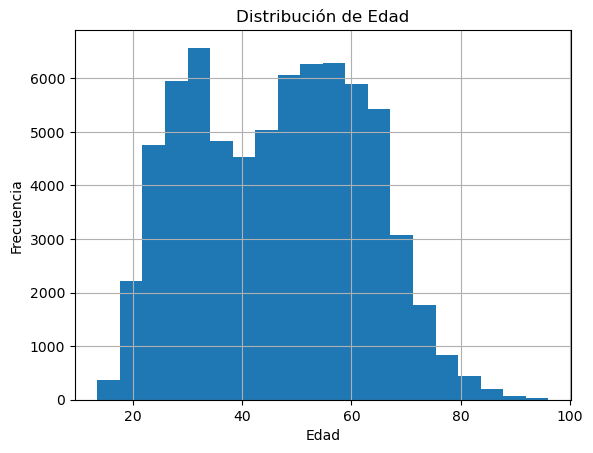

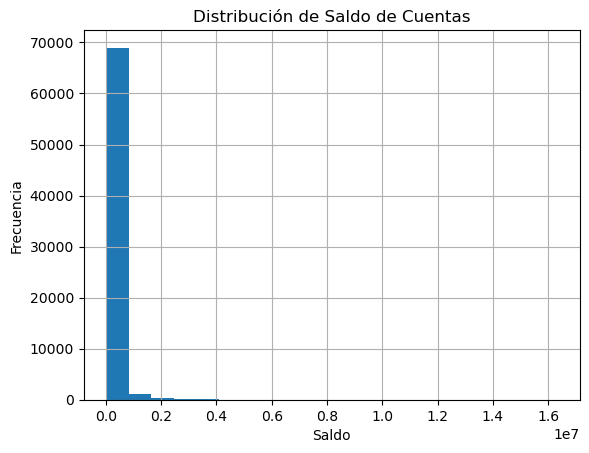

In [18]:
# Ejemplo de distribución de edad
df_final_demo['clnt_age'].hist(bins=20)
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

# Ejemplo de distribución de saldo de cuentas
df_final_demo['bal'].hist(bins=20)
plt.title('Distribución de Saldo de Cuentas')
plt.xlabel('Saldo')
plt.ylabel('Frecuencia')
plt.show()


- Limpieza de datos

- Eliminación de valores nulos en df_final_demo, solo 14-15 filas de 70609

In [19]:
df_final_demo = df_final_demo.dropna()

In [20]:
df_final_demo.isnull().sum()

client_id           0
clnt_tenure_yr      0
clnt_tenure_mnth    0
clnt_age            0
gendr               0
num_accts           0
bal                 0
calls_6_mnth        0
logons_6_mnth       0
dtype: int64

- Detección de duplicados

In [21]:
duplicados_demo = df_final_demo.duplicated()
duplicados_experiment_clients = df_final_experiment_clients.duplicated()
duplicados_pt = df_pt.duplicated()

In [22]:
df_final_demo[duplicados_demo]

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth


In [23]:
df_final_experiment_clients[duplicados_experiment_clients]

,client_id,Variation


In [24]:
df_pt[duplicados_pt]

,client_id,visitor_id,visit_id,process_step,date_time
365,9358626,148475529_63668223960,223297395_36250329195_832161,start,2017-04-28 12:27:28
368,5376894,622509328_44408201172,688984457_43441834354_912755,start,2017-04-28 14:20:01
383,438567,923318467_50708963627,330543236_29863358529_771432,start,2017-04-28 02:52:29
785,1423857,716830992_81930238382,568819166_80596727019_75889,confirm,2017-04-10 22:44:58
1816,372523,730241475_25771921122,25331354_74479847014_854987,start,2017-04-27 10:51:26
...,...,...,...,...,...
755261,1672289,658797407_91003097342,430110748_90347503221_597628,start,2017-05-01 19:28:53
755304,4408245,14058946_73585431797,994148957_84373994761_991865,start,2017-06-06 09:17:23
755306,4408245,14058946_73585431797,994148957_84373994761_991865,start,2017-06-06 09:09:44
755308,4408245,14058946_73585431797,994148957_84373994761_991865,start,2017-06-06 08:51:16


In [25]:
num_duplicados_pt = df_pt.duplicated().sum()
print(f"Duplicados en df_pt: {num_duplicados_pt}")

Duplicados en df_pt: 10764


- Eliminación de duplicados en df_pt

In [26]:
df_pt = df_pt.drop_duplicates()

In [27]:
num_duplicados_pt = df_pt.duplicated().sum()
print(f"Duplicados en df_pt: {num_duplicados_pt}")

Duplicados en df_pt: 0


- Actualización de datos

In [28]:
df_final_demo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70594 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         70594 non-null  int64  
 1   clnt_tenure_yr    70594 non-null  float64
 2   clnt_tenure_mnth  70594 non-null  float64
 3   clnt_age          70594 non-null  float64
 4   gendr             70594 non-null  object 
 5   num_accts         70594 non-null  float64
 6   bal               70594 non-null  float64
 7   calls_6_mnth      70594 non-null  float64
 8   logons_6_mnth     70594 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 5.4+ MB


In [29]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744641 entries, 0 to 755404
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     744641 non-null  int64 
 1   visitor_id    744641 non-null  object
 2   visit_id      744641 non-null  object
 3   process_step  744641 non-null  object
 4   date_time     744641 non-null  object
dtypes: int64(1), object(4)
memory usage: 34.1+ MB


In [30]:
df_final_experiment_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  70609 non-null  int64 
 1   Variation  50500 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


- No existe forma de detectar el variation a partir de los campos de las otras tablas, tenemos que hacer drop de nulos para tener la tabla limpia.

In [31]:
df_final_experiment_clients = df_final_experiment_clients.dropna()

In [32]:
df_final_experiment_clients.isnull().sum()

client_id    0
Variation    0
dtype: int64

- Nos quedamos solo con los registros que tengan un client_id común en las tres tablas (df_final_demo, df_final_experiment_clients y df_pt). Esto te permitirá unificar la información y trabajar con un conjunto de datos consistente.

- Función set.intersection() para encontrar los client_id que están presentes en las tres tablas.

In [33]:
# Identificar los client_id presentes en cada tabla
client_ids_demo = set(df_final_demo['client_id'])
client_ids_experiment = set(df_final_experiment_clients['client_id'])
client_ids_pt = set(df_pt['client_id'])

# Encontrar la intersección de los tres conjuntos
client_ids_comunes = client_ids_demo.intersection(client_ids_experiment).intersection(client_ids_pt)

# Verificar la cantidad de client_id comunes
print(f"Número de client_id comunes en las tres tablas: {len(client_ids_comunes)}")

Número de client_id comunes en las tres tablas: 50487


In [34]:
# Filtrar df_final_demo
df_final_demo= df_final_demo[df_final_demo['client_id'].isin(client_ids_comunes)]

# Filtrar df_final_experiment_clients
df_final_experiment_clients = df_final_experiment_clients[df_final_experiment_clients['client_id'].isin(client_ids_comunes)]

# Filtrar df_pt
df_pt= df_pt[df_pt['client_id'].isin(client_ids_comunes)]

# Verificar las dimensiones de las tablas filtradas
print(f"Dimensiones de df_final_demo: {df_final_demo.shape}")
print(f"Dimensiones de df_final_experiment_clients: {df_final_experiment_clients.shape}")
print(f"Dimensiones de df_pt: {df_pt.shape}")


Dimensiones de df_final_demo: (50487, 9)
Dimensiones de df_final_experiment_clients: (50487, 2)
Dimensiones de df_pt: (317123, 5)


- df_pt tiene más registros porque se representan ahí los pasos del experimento entonces se repiten los id para cada paso del mismo cliente.

In [35]:
df_final_demo

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...,...
50495,1780858,21.0,262.0,68.5,M,3.0,372100.59,6.0,9.0
50496,6967120,21.0,260.0,68.5,M,3.0,4279873.38,6.0,9.0
50497,5826160,20.0,249.0,56.5,F,2.0,44837.16,2.0,5.0
50498,8739285,19.0,229.0,69.5,F,2.0,44994.24,1.0,4.0


In [36]:
df_final_demo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50487 entries, 0 to 50499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         50487 non-null  int64  
 1   clnt_tenure_yr    50487 non-null  float64
 2   clnt_tenure_mnth  50487 non-null  float64
 3   clnt_age          50487 non-null  float64
 4   gendr             50487 non-null  object 
 5   num_accts         50487 non-null  float64
 6   bal               50487 non-null  float64
 7   calls_6_mnth      50487 non-null  float64
 8   logons_6_mnth     50487 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 3.9+ MB


In [37]:
df_final_experiment_clients

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
50495,393005,Control
50496,2908510,Control
50497,7230446,Test
50498,5230357,Test


In [38]:
df_final_experiment_clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50487 entries, 0 to 50499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  50487 non-null  int64 
 1   Variation  50487 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [39]:
df_pt

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
637487,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27
637532,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17
637533,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31
637534,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23


In [40]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 317123 entries, 0 to 637535
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     317123 non-null  int64 
 1   visitor_id    317123 non-null  object
 2   visit_id      317123 non-null  object
 3   process_step  317123 non-null  object
 4   date_time     317123 non-null  object
dtypes: int64(1), object(4)
memory usage: 14.5+ MB


- Conversión de tipos.

In [41]:
df_final_demo['clnt_tenure_yr'] = df_final_demo['clnt_tenure_yr'].astype(int)
df_final_demo['clnt_tenure_mnth'] = df_final_demo['clnt_tenure_mnth'].astype(int)
df_final_demo['num_accts'] = df_final_demo['num_accts'].astype(int)
df_final_demo['calls_6_mnth'] = df_final_demo['calls_6_mnth'].astype(int)
df_final_demo['logons_6_mnth'] = df_final_demo['logons_6_mnth'].astype(int)

In [42]:
df_final_demo.dtypes

client_id             int64
clnt_tenure_yr        int32
clnt_tenure_mnth      int32
clnt_age            float64
gendr                object
num_accts             int32
bal                 float64
calls_6_mnth          int32
logons_6_mnth         int32
dtype: object

- Conversión de la columna date_time de object a datetime.

In [43]:
df_pt['date_time'] = pd.to_datetime(df_pt['date_time'])

In [44]:
df_pt.dtypes

client_id                int64
visitor_id              object
visit_id                object
process_step            object
date_time       datetime64[ns]
dtype: object

In [45]:
df_pt[['date_time']].head()

,date_time
0,2017-04-17 15:27:07
1,2017-04-17 15:26:51
2,2017-04-17 15:19:22
3,2017-04-17 15:19:13
4,2017-04-17 15:18:04


- Renombrar df.

In [46]:
df_final = df_final_experiment_clients

- Renombrado de columnas.

In [47]:
df_pt = df_pt.rename(columns={'process_step': 'step'})

In [48]:
df_final_demo = df_final_demo.rename(columns={
    'clnt_tenure_yr': 'tenure_years',
    'clnt_tenure_mnth': 'tenure_months',
    'clnt_age': 'age',
    'gendr': 'gender',
    'num_accts': 'num_accounts',
    'bal': 'balance',
    'calls_6_mnth': 'calls_6_months',
    'logons_6_mnth': 'logons_6_months'
})

In [49]:
df_final

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
50495,393005,Control
50496,2908510,Control
50497,7230446,Test
50498,5230357,Test


In [50]:
df_final_demo

,client_id,tenure_years,tenure_months,age,gender,num_accounts,balance,calls_6_months,logons_6_months
0,836976,6,73,60.5,U,2,45105.30,6,9
1,2304905,7,94,58.0,U,2,110860.30,6,9
2,1439522,5,64,32.0,U,2,52467.79,6,9
3,1562045,16,198,49.0,M,2,67454.65,3,6
4,5126305,12,145,33.0,F,2,103671.75,0,3
...,...,...,...,...,...,...,...,...,...
50495,1780858,21,262,68.5,M,3,372100.59,6,9
50496,6967120,21,260,68.5,M,3,4279873.38,6,9
50497,5826160,20,249,56.5,F,2,44837.16,2,5
50498,8739285,19,229,69.5,F,2,44994.24,1,4


In [51]:
df_pt

,client_id,visitor_id,visit_id,step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
637487,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27
637532,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17
637533,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31
637534,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23


- Unión de df_final y df_final_demo

In [52]:
df_final = pd.merge(df_final, df_final_demo, on='client_id', how='inner')

In [53]:
df_final

,client_id,Variation,tenure_years,tenure_months,age,gender,num_accounts,balance,calls_6_months,logons_6_months
0,9988021,Test,5,64,79.0,U,2,189023.86,1,4
1,8320017,Test,22,274,34.5,M,2,36001.90,5,8
2,4033851,Control,12,149,63.5,M,2,142642.26,5,8
3,1982004,Test,6,80,44.5,U,2,30231.76,1,4
4,9294070,Control,5,70,29.0,U,2,34254.54,0,3
...,...,...,...,...,...,...,...,...,...,...
50482,393005,Control,15,191,52.5,M,2,60344.67,1,4
50483,2908510,Control,21,252,34.0,M,3,141808.05,6,9
50484,7230446,Test,6,74,62.0,M,2,58778.11,2,5
50485,5230357,Test,23,278,30.5,M,2,61349.70,0,3


In [54]:
df_final = df_final.rename(columns={'Variation': 'variation'})

In [55]:
df_final

,client_id,variation,tenure_years,tenure_months,age,gender,num_accounts,balance,calls_6_months,logons_6_months
0,9988021,Test,5,64,79.0,U,2,189023.86,1,4
1,8320017,Test,22,274,34.5,M,2,36001.90,5,8
2,4033851,Control,12,149,63.5,M,2,142642.26,5,8
3,1982004,Test,6,80,44.5,U,2,30231.76,1,4
4,9294070,Control,5,70,29.0,U,2,34254.54,0,3
...,...,...,...,...,...,...,...,...,...,...
50482,393005,Control,15,191,52.5,M,2,60344.67,1,4
50483,2908510,Control,21,252,34.0,M,3,141808.05,6,9
50484,7230446,Test,6,74,62.0,M,2,58778.11,2,5
50485,5230357,Test,23,278,30.5,M,2,61349.70,0,3


- Determinar los clientes más importantes del df de acuerdo a factores como tenure, num_accounts, balance, calls_6_months y logons_6_months

- Sacamos la media de estas columnas y calculamos el percentil 90 para calcular a continuación el top 10% clientes.

In [56]:
# Calcular la media de cada columna.
mean_tenure = df_final['tenure_years'].mean()
mean_balance = df_final['balance'].mean()
mean_num_accounts = df_final['num_accounts'].mean()
mean_activity = (df_final['calls_6_months'] + df_final['logons_6_months']).mean()

In [57]:
# Calcular el percentil 90 de cada columna.
percentile_90_tenure = df_final['tenure_years'].quantile(0.90)
percentile_90_balance = df_final['balance'].quantile(0.90)
percentile_90_num_accounts = df_final['num_accounts'].quantile(0.90)
percentile_90_activity = (df_final['calls_6_months'] + df_final['logons_6_months']).quantile(0.90)

- Clientes por encima de la media.

In [58]:
df_above_mean = df_final[
    (df_final['tenure_years'] > mean_tenure) &
    (df_final['balance'] > mean_balance) &
    (df_final['num_accounts'] > mean_num_accounts) &
    ((df_final['calls_6_months'] + df_final['logons_6_months']) > mean_activity)
]

In [59]:
df_above_mean

,client_id,variation,tenure_years,tenure_months,age,gender,num_accounts,balance,calls_6_months,logons_6_months
19,949210,Test,29,355,54.5,M,4,1219029.31,4,7
31,800925,Control,20,246,70.0,F,3,1089355.22,6,9
90,5408845,Test,33,396,53.0,M,4,287596.87,4,7
102,6653427,Test,23,282,52.5,F,3,561725.24,5,8
106,8188670,Control,28,342,69.0,M,3,755574.17,6,9
...,...,...,...,...,...,...,...,...,...,...
50398,2058346,Control,22,270,21.0,F,3,219491.49,6,9
50402,4498441,Test,15,187,57.0,F,3,301618.98,6,9
50414,7487053,Test,27,331,52.5,M,3,1176274.37,6,9
50440,2339876,Test,29,349,82.5,F,3,243989.31,6,9


- Clientes top 10%

In [60]:
df_top_10 = df_final[
    (df_final['tenure_years'] >= percentile_90_tenure) &
    (df_final['balance'] >= percentile_90_balance) &
    (df_final['num_accounts'] >= percentile_90_num_accounts) &
    ((df_final['calls_6_months'] + df_final['logons_6_months']) >= percentile_90_activity)
]

In [61]:
df_top_10

,client_id,variation,tenure_years,tenure_months,age,gender,num_accounts,balance,calls_6_months,logons_6_months
106,8188670,Control,28,342,69.0,M,3,755574.17,6,9
187,4256611,Test,24,292,51.5,M,3,3592350.60,6,9
273,2289897,Control,25,303,74.0,M,5,538260.91,6,9
526,6199584,Test,29,358,59.5,M,4,976666.93,6,9
547,3045158,Control,34,419,60.5,M,3,620316.97,6,9
...,...,...,...,...,...,...,...,...,...,...
49723,3035988,Control,27,333,67.0,M,4,402003.17,6,9
50182,2922807,Control,28,336,59.0,M,3,494572.00,6,9
50183,5735570,Test,37,451,73.0,M,3,6000386.82,6,9
50361,293002,Control,22,270,64.0,F,3,392927.00,6,9


- Creamos una nueva columna para indicar a qué grupo pertenece cada cliente, si está en el grupo 'general' o por encima de la media o es top 10%

- Asignamos el grupo 'Above Mean' solo a aquellos que no están en Top 10%

In [62]:
df_final['group'] = 'General'

df_final.loc[df_final['client_id'].isin(df_top_10['client_id']), 'group'] = 'Top 10%'

df_final.loc[
    (df_final['tenure_years'] > mean_tenure) &
    (df_final['balance'] > mean_balance) &
    (df_final['num_accounts'] > mean_num_accounts) &
    ((df_final['calls_6_months'] + df_final['logons_6_months']) > mean_activity) &
    (df_final['group'] == 'General'),
    'group'
] = 'Above Mean'


In [63]:
df_final

,client_id,variation,tenure_years,tenure_months,age,gender,num_accounts,balance,calls_6_months,logons_6_months,group
0,9988021,Test,5,64,79.0,U,2,189023.86,1,4,General
1,8320017,Test,22,274,34.5,M,2,36001.90,5,8,General
2,4033851,Control,12,149,63.5,M,2,142642.26,5,8,General
3,1982004,Test,6,80,44.5,U,2,30231.76,1,4,General
4,9294070,Control,5,70,29.0,U,2,34254.54,0,3,General
...,...,...,...,...,...,...,...,...,...,...,...
50482,393005,Control,15,191,52.5,M,2,60344.67,1,4,General
50483,2908510,Control,21,252,34.0,M,3,141808.05,6,9,General
50484,7230446,Test,6,74,62.0,M,2,58778.11,2,5,General
50485,5230357,Test,23,278,30.5,M,2,61349.70,0,3,General


In [64]:
df_final['group'].value_counts()

group
General       48188
Above Mean     1875
Top 10%         424
Name: count, dtype: int64

- Visualización de la distribución de balance con un Boxplot.

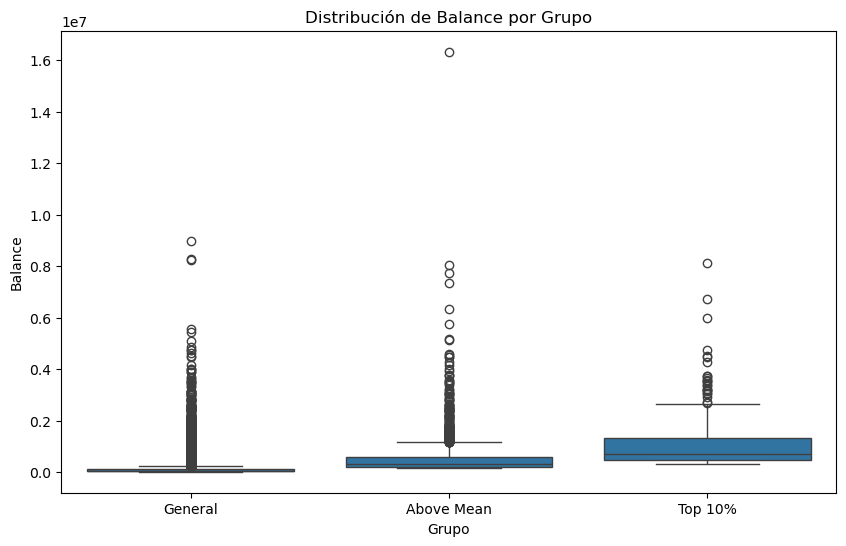

In [65]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='balance', data=df_final)
plt.title('Distribución de Balance por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Balance')
plt.show()

- Visualización de la distribución de tenure_years con un Gráfico de Barras.

C:\Users\usr\AppData\Local\Temp\ipykernel_10632\1119270055.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='group', y='tenure_years', data=df_final, estimator='mean', ci=None)


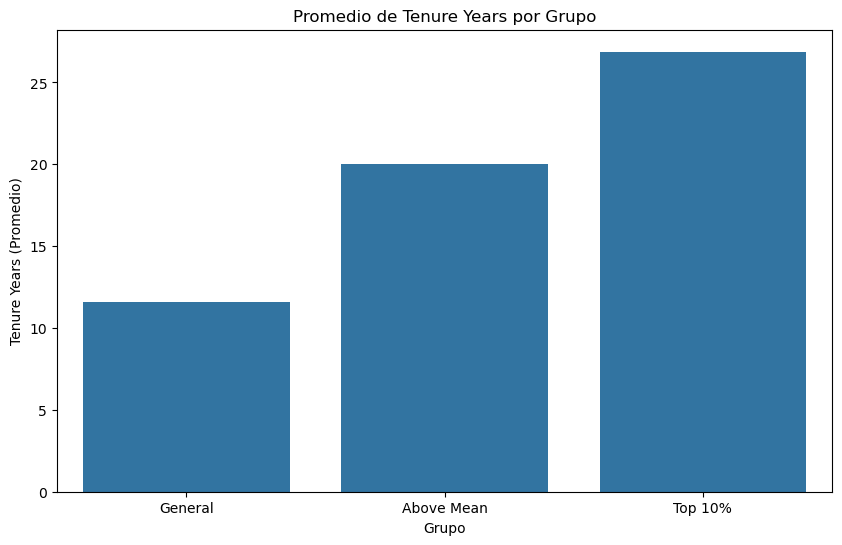

In [66]:
plt.figure(figsize=(10, 6))
sns.barplot(x='group', y='tenure_years', data=df_final, estimator='mean', ci=None)
plt.title('Promedio de Tenure Years por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Tenure Years (Promedio)')
plt.show()

- Boxplot de la distribución de tenure_years por grupo.

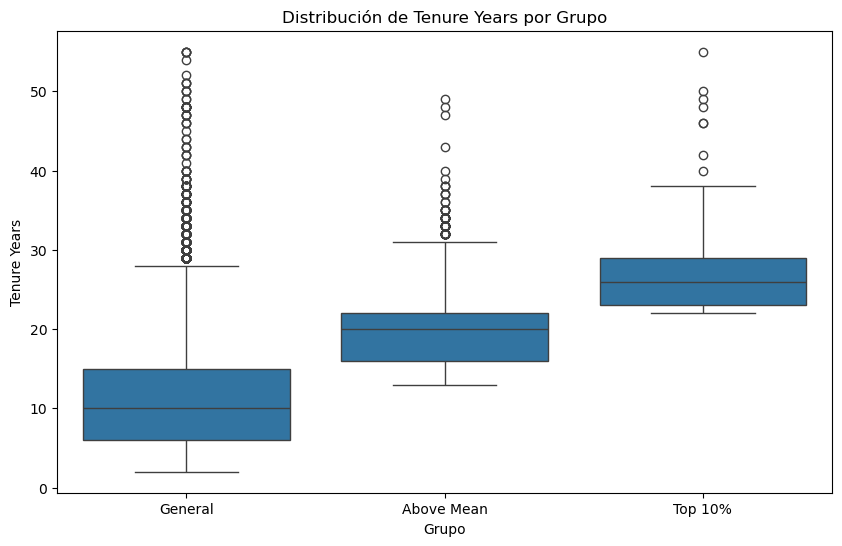

In [79]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='tenure_years', data=df_final)
plt.title('Distribución de Tenure Years por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Tenure Years')
plt.show()

- Visualización de la actividad reciente (suma de calls_6_months y logons_6_months) con un Boxplot.

- Creamos una columna para la actividad reciente.

In [67]:
df_final['activity'] = df_final['calls_6_months'] + df_final['logons_6_months']

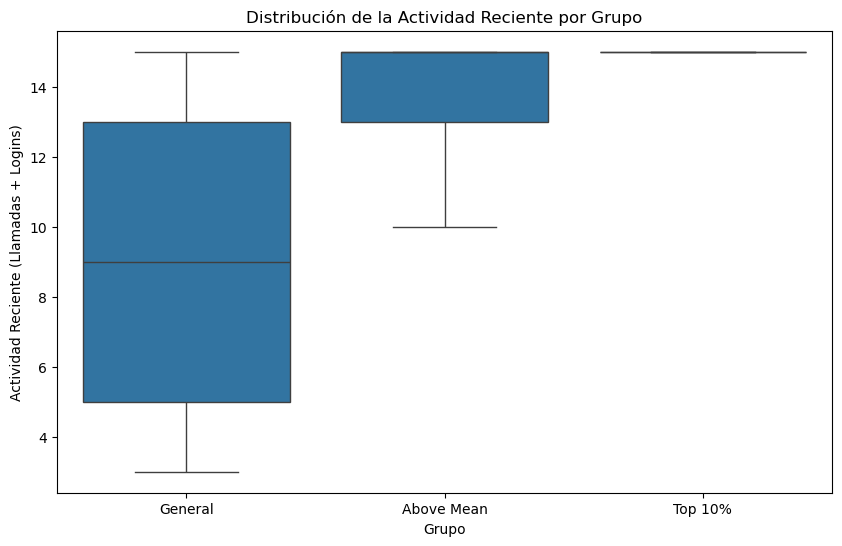

In [68]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='activity', data=df_final)
plt.title('Distribución de la Actividad Reciente por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Actividad Reciente (Llamadas + Logins)')
plt.show()

- Visualización del número de cuentas (num_accounts) por grupo con un Gráfico de Barras.

C:\Users\usr\AppData\Local\Temp\ipykernel_10632\644004275.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='group', y='num_accounts', data=df_final, estimator='mean', ci=None)


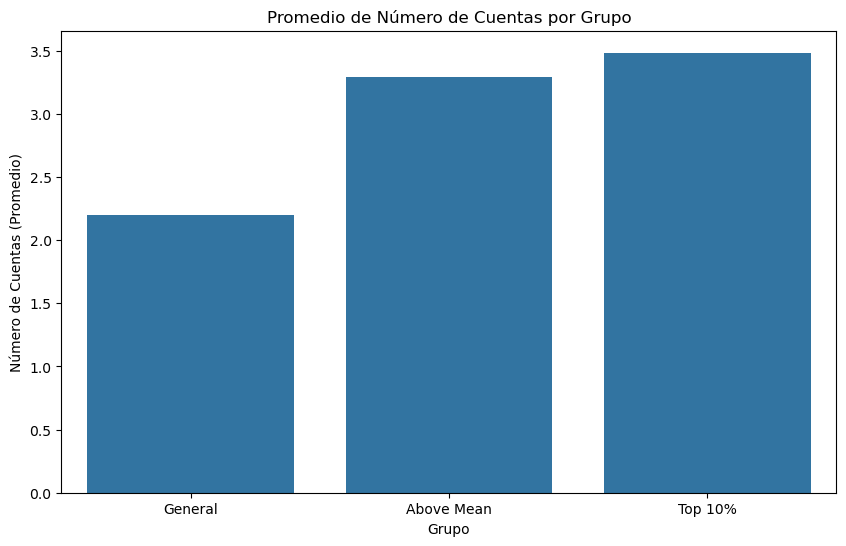

In [69]:
plt.figure(figsize=(10, 6))
sns.barplot(x='group', y='num_accounts', data=df_final, estimator='mean', ci=None)
plt.title('Promedio de Número de Cuentas por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de Cuentas (Promedio)')
plt.show()

- Scatter plot de balance vs. tenure_years

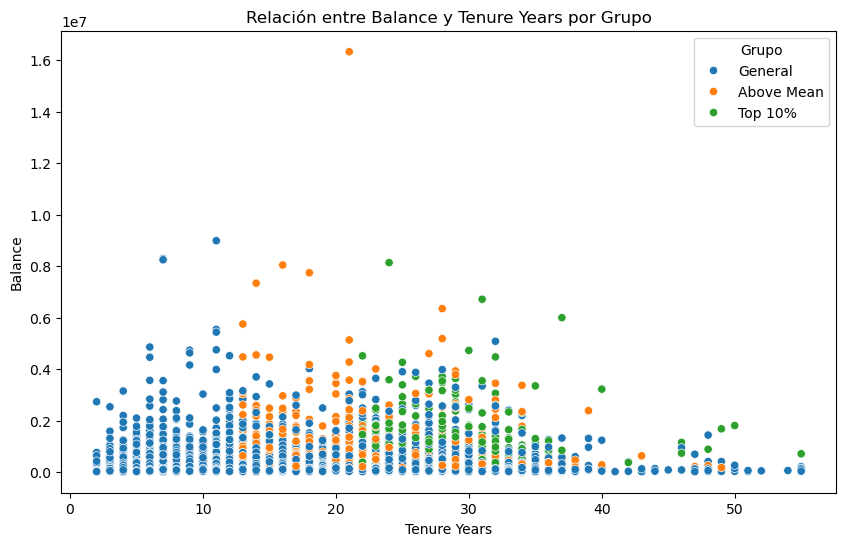

In [70]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tenure_years', y='balance', hue='group', data=df_final)
plt.title('Relación entre Balance y Tenure Years por Grupo')
plt.xlabel('Tenure Years')
plt.ylabel('Balance')
plt.legend(title='Grupo')
plt.show()

- Boxplot de la distribución de la edad por grupo.

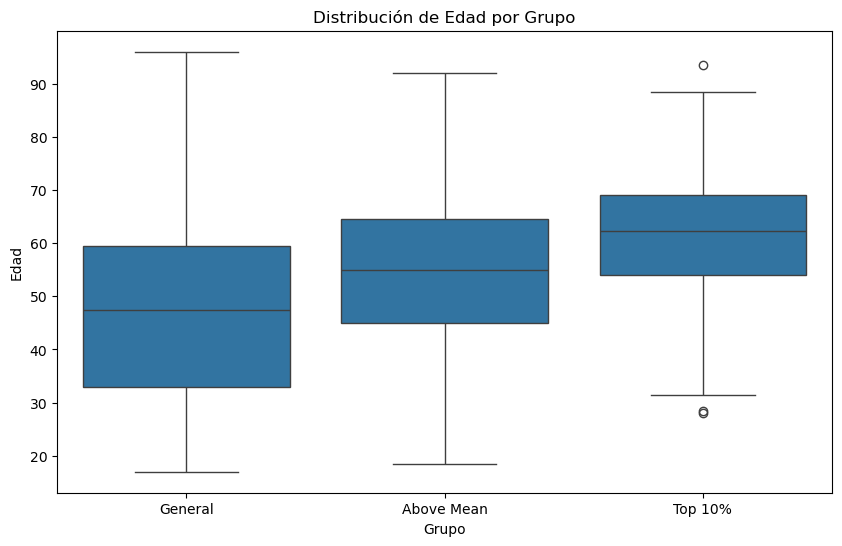

In [74]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='age', data=df_final)
plt.title('Distribución de Edad por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Edad')
plt.show()

- Promedio de la edad por grupo.

In [76]:
mean_age_by_group = df_final.groupby('group')['age'].mean()
mean_age_by_group

group
Above Mean    54.536800
General       46.911181
Top 10%       61.844340
Name: age, dtype: float64

- Visualización del promedio de edad por grupo

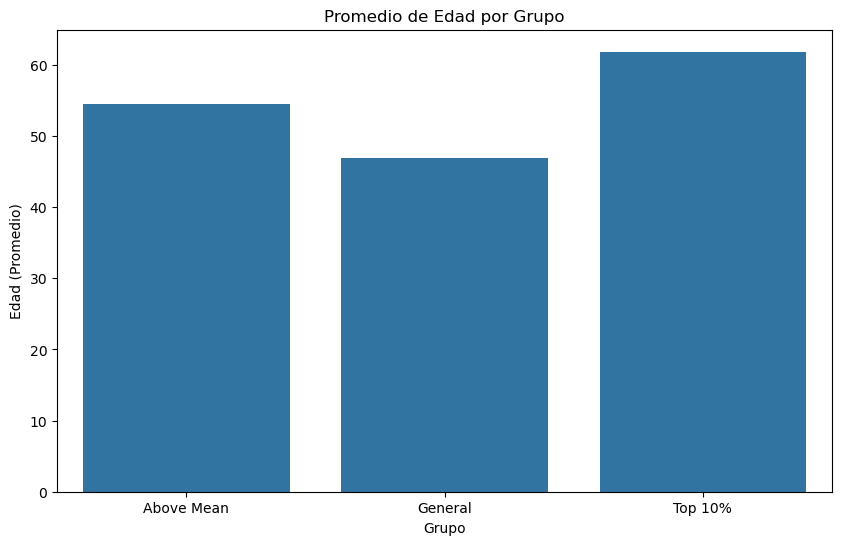

In [77]:
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_age_by_group.index, y=mean_age_by_group.values)
plt.title('Promedio de Edad por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Edad (Promedio)')
plt.show()

- Nueva columna para la clasificación de edad.

In [81]:
df_final['age_group'] = pd.cut(df_final['age'], bins=[0, 35, 55, 100], labels=['Young', 'Middle-aged', 'Senior'])

In [82]:
df_final['age_group'].value_counts()

age_group
Middle-aged    18486
Senior         17673
Young          14328
Name: count, dtype: int64

- Distribución de clientes por grupo de edad y grupo general.

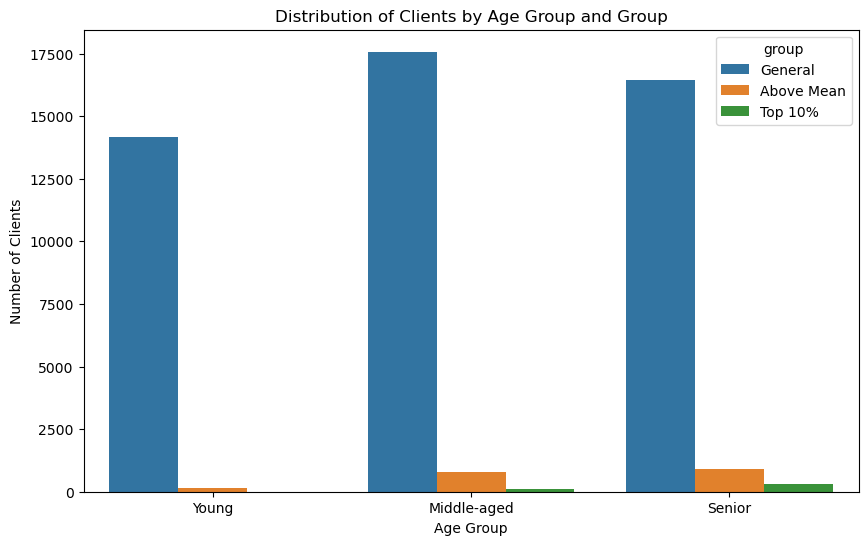

In [83]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='group', data=df_final)
plt.title('Distribution of Clients by Age Group and Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Clients')
plt.show()

- Promedio de balance por grupo de edad y grupo general.

C:\Users\usr\AppData\Local\Temp\ipykernel_10632\1266350530.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='age_group', y='balance', hue='group', data=df_final, estimator='mean', ci=None)


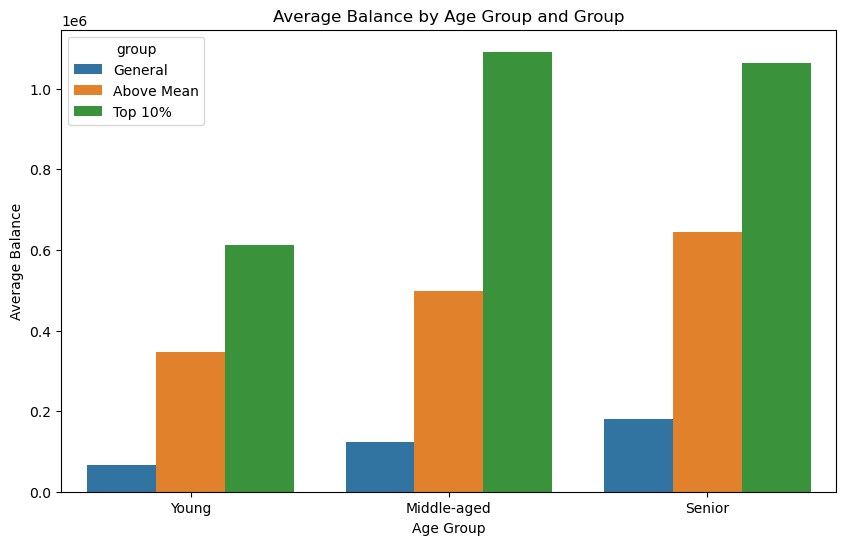

In [84]:
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='balance', hue='group', data=df_final, estimator='mean', ci=None)
plt.title('Average Balance by Age Group and Group')
plt.xlabel('Age Group')
plt.ylabel('Average Balance')
plt.show()

- Promedio de tenure years por grupo de edad y grupo general.

C:\Users\usr\AppData\Local\Temp\ipykernel_10632\1346673204.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='age_group', y='tenure_years', hue='group', data=df_final, estimator='mean', ci=None)


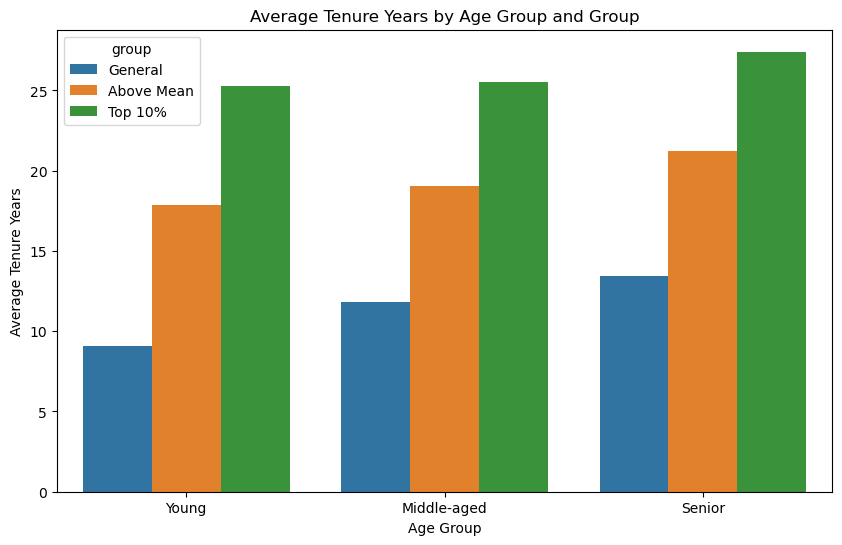

In [85]:
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='tenure_years', hue='group', data=df_final, estimator='mean', ci=None)
plt.title('Average Tenure Years by Age Group and Group')
plt.xlabel('Age Group')
plt.ylabel('Average Tenure Years')
plt.show()

- Actividad reciente por grupo de edad y grupo general.

C:\Users\usr\AppData\Local\Temp\ipykernel_10632\1704854293.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='age_group', y='activity', hue='group', data=df_final, estimator='mean', ci=None)


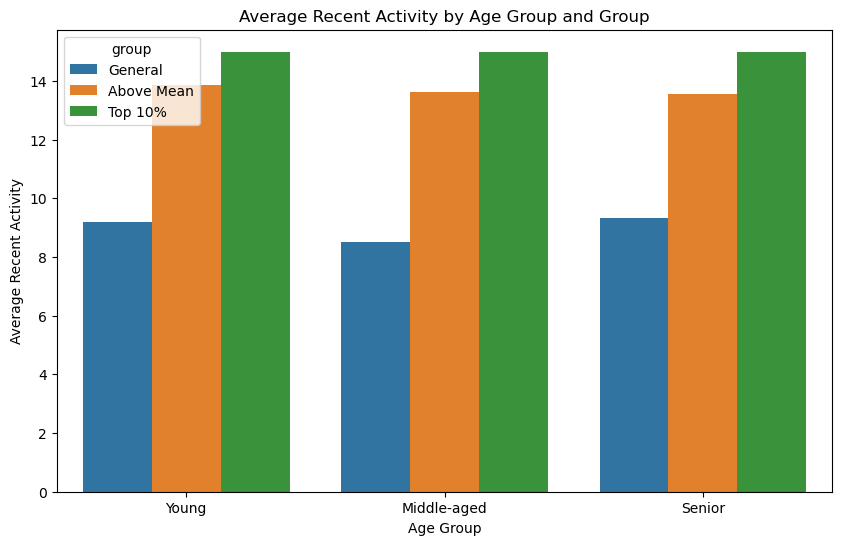

In [86]:
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='activity', hue='group', data=df_final, estimator='mean', ci=None)
plt.title('Average Recent Activity by Age Group and Group')
plt.xlabel('Age Group')
plt.ylabel('Average Recent Activity')
plt.show()

- Crosstab para observar la relación entre las categorías de grupos de clientes y grupos de edad, comparación de variables categóricas.

In [87]:
crosstab_age_group = pd.crosstab(df_final['age_group'], df_final['group'], normalize='index')

In [88]:
crosstab_age_group

group,Above Mean,General,Top 10%
age_group,,,
Young,0.011097,0.988624,0.000279
Middle-aged,0.043006,0.950719,0.006275
Senior,0.052113,0.930685,0.017201


- Visualización con un heatmap para ver las proporciones.

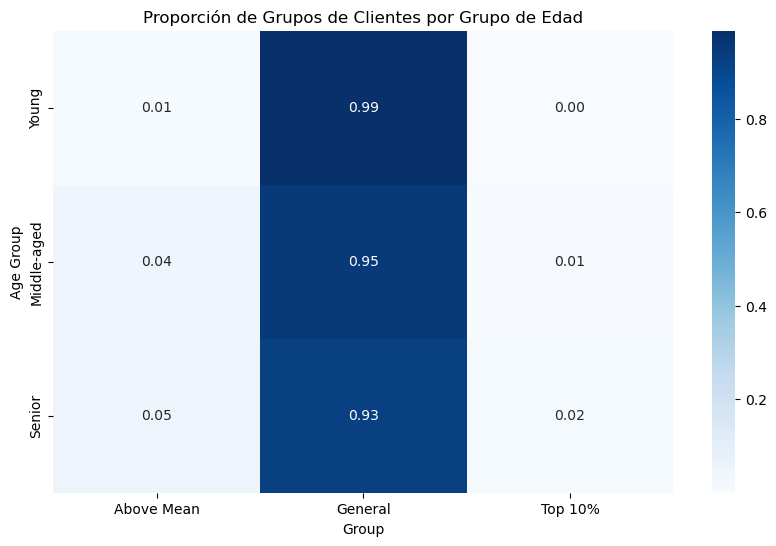

In [89]:
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_age_group, annot=True, cmap='Blues', fmt='.2f')
plt.title('Proporción de Grupos de Clientes por Grupo de Edad')
plt.xlabel('Group')
plt.ylabel('Age Group')
plt.show()

- Distribución sesgada, hay muy pocos clientes en Above Mean y Top 10% comparado con el General Group.

- Hacemos Plotchart para visualizar mejor.
- Crosstab sin normalizar para contar simplemente las frecuencias brutas y ver mejor la representación.

In [97]:
crosstab_age_group_raw = pd.crosstab(df_final['age_group'], df_final['group'])

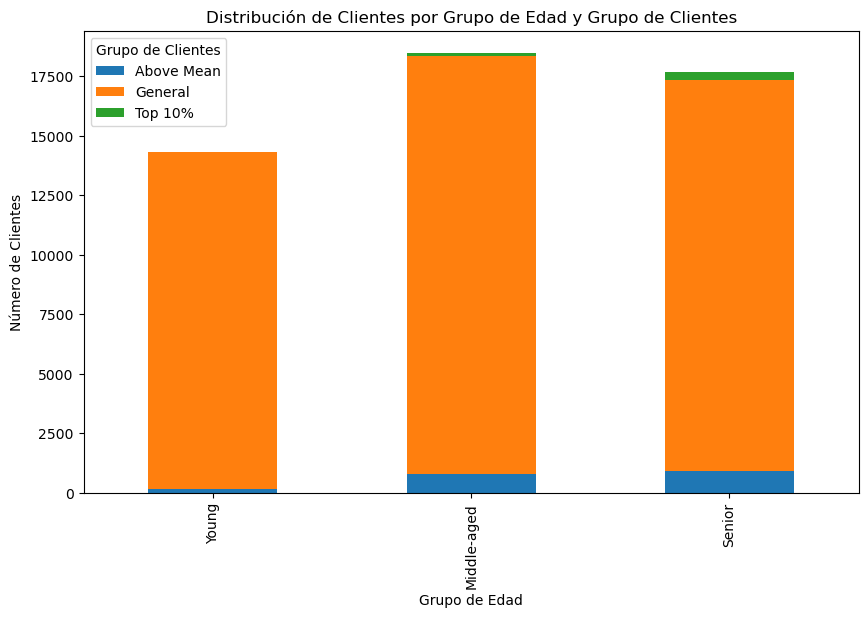

In [98]:
crosstab_age_group_raw.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de Clientes por Grupo de Edad y Grupo de Clientes')
plt.xlabel('Grupo de Edad')
plt.ylabel('Número de Clientes')
plt.legend(title='Grupo de Clientes')
plt.show()

- Crosstab y Plotbar para ver las proporciones dentro de cada grupo de clientes.

In [100]:
crosstab_group_age_prop = pd.crosstab(df_final['group'], df_final['age_group'], normalize='index')

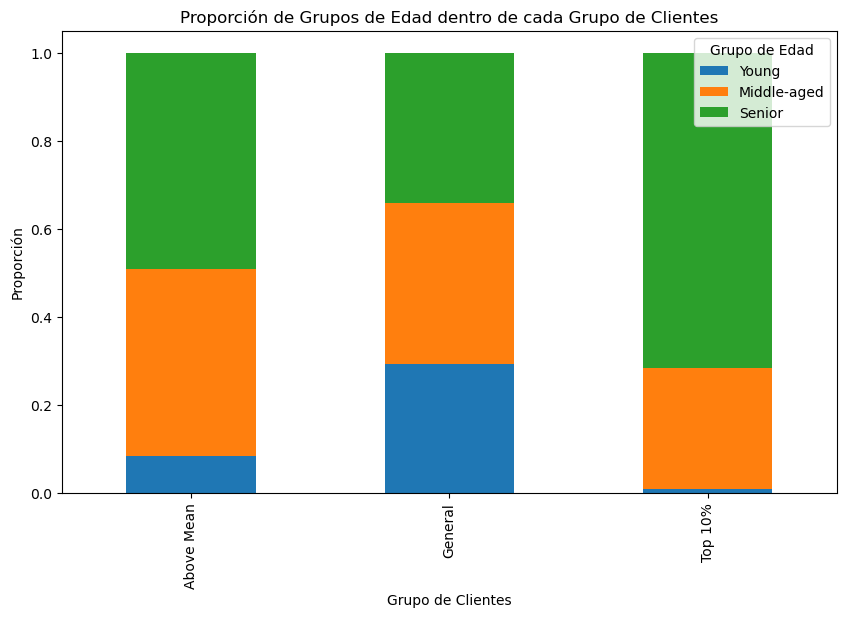

In [101]:
crosstab_group_age_prop.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proporción de Grupos de Edad dentro de cada Grupo de Clientes')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Proporción')
plt.legend(title='Grupo de Edad')
plt.show()

- Análisis por separado de los grupos 'Above Mean' y 'Top 10%'

In [103]:
df_above_mean = df_final[df_final['group'] == 'Above Mean']
df_top_10 = df_final[df_final['group'] == 'Top 10%']

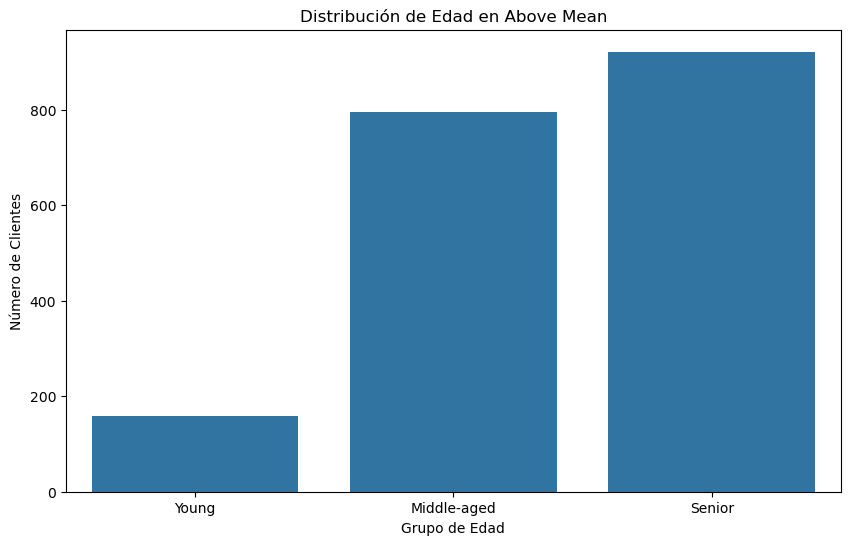

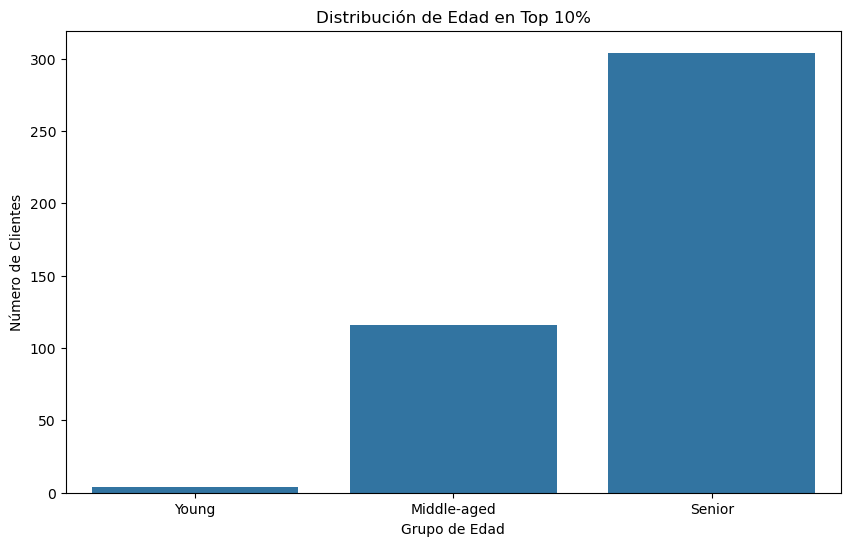

In [104]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', data=df_above_mean)
plt.title('Distribución de Edad en Above Mean')
plt.xlabel('Grupo de Edad')
plt.ylabel('Número de Clientes')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', data=df_top_10)
plt.title('Distribución de Edad en Top 10%')
plt.xlabel('Grupo de Edad')
plt.ylabel('Número de Clientes')
plt.show()

- Crosstab de group vs num_accounts -> ¿Los clientes en el Top 10% tienden a tener más cuentas con la empresa en comparación con el resto?

In [105]:
crosstab_group_accounts = pd.crosstab(df_final['group'], df_final['num_accounts'])
crosstab_group_accounts

num_accounts,1,2,3,4,5,6,7
group,,,,,,,
Above Mean,0,0,1406,392,68,9,0
General,1,39720,7276,1070,110,7,4
Top 10%,0,0,265,123,27,7,2


- Plotbar de group vs num_accounts

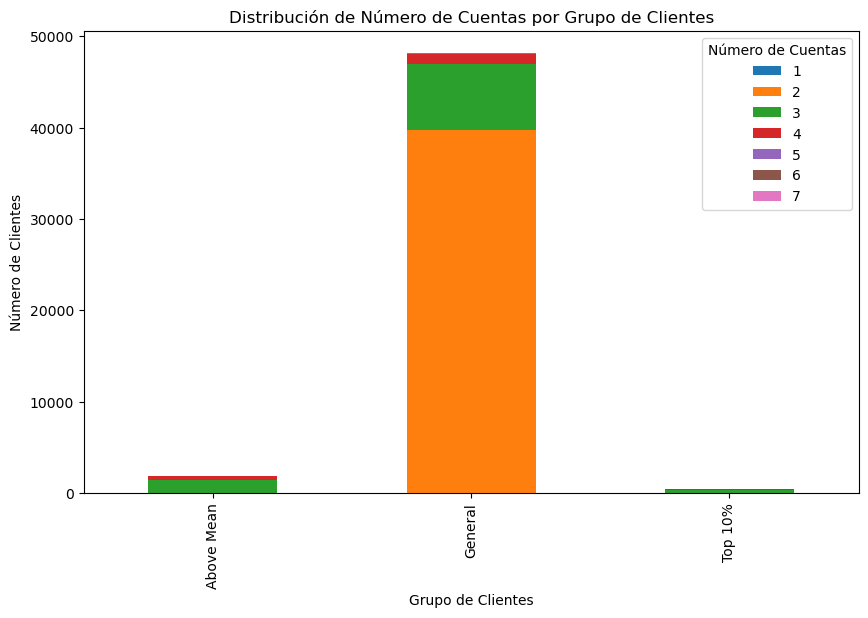

In [108]:
crosstab_group_accounts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de Número de Cuentas por Grupo de Clientes')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Número de Clientes')
plt.legend(title='Número de Cuentas')
plt.show()

- Crosstab de age_group vs. balance -> ¿Los clientes más jóvenes (Young) tienden a tener balances más bajos en comparación con los clientes mayores (Senior)?

In [106]:
# Clasificar el balance en categorías
df_final['balance_category'] = pd.qcut(df_final['balance'], q=3, labels=['Low', 'Medium', 'High'])

In [107]:
crosstab_age_balance = pd.crosstab(df_final['age_group'], df_final['balance_category'])
crosstab_age_balance

balance_category,Low,Medium,High
age_group,,,
Young,7026,5379,1923
Middle-aged,5732,6376,6378
Senior,4071,5074,8528


- Heatmap de age_group vs. balance

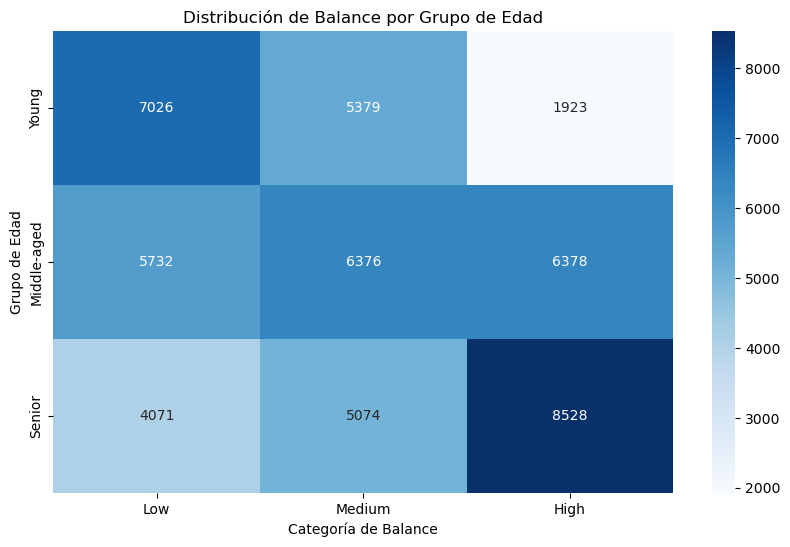

In [109]:
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_age_balance, annot=True, cmap='Blues', fmt='d')
plt.title('Distribución de Balance por Grupo de Edad')
plt.xlabel('Categoría de Balance')
plt.ylabel('Grupo de Edad')
plt.show()

- Crosstab de group vs. activity -> ¿Los clientes en el Top 10% muestran una mayor actividad reciente en comparación con los otros grupos?

In [110]:
# Clasificar la actividad en categorías
df_final['activity_category'] = pd.qcut(df_final['activity'], q=3, labels=['Low', 'Medium', 'High'])

In [111]:
crosstab_group_activity = pd.crosstab(df_final['group'], df_final['activity_category'])
crosstab_group_activity

activity_category,Low,Medium,High
group,,,
Above Mean,0,872,1003
General,22513,14777,10898
Top 10%,0,0,424


- Plotbar de group vs. activity

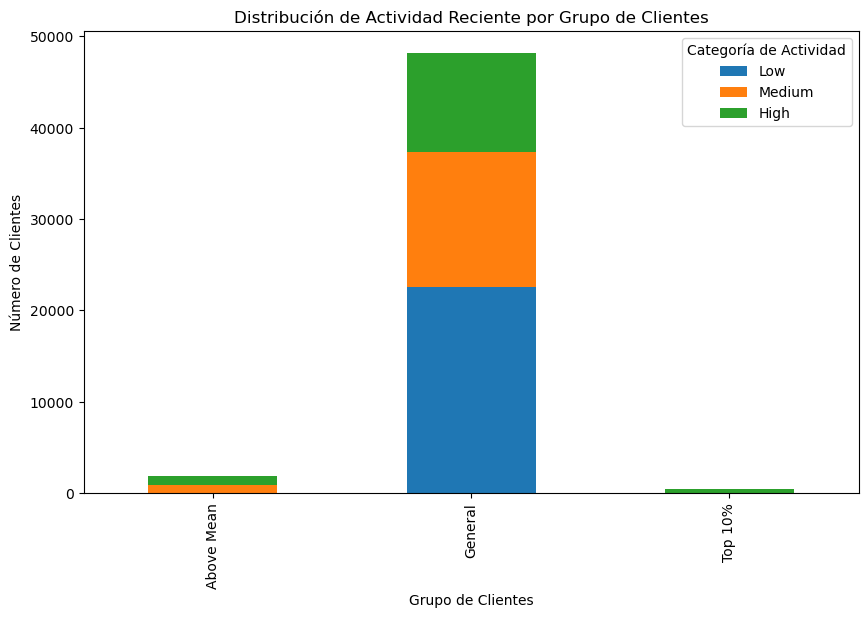

In [115]:
crosstab_group_activity.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de Actividad Reciente por Grupo de Clientes')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Número de Clientes')
plt.legend(title='Categoría de Actividad')
plt.show()

- Crosstab de group vs. gender -> ¿Hay una distribución de género que favorezca a un grupo particular de clientes? Por ejemplo, ¿son más hombres o mujeres los que están en el Top 10%?

In [112]:
crosstab_group_gender = pd.crosstab(df_final['group'], df_final['gender'])
crosstab_group_gender

gender,F,M,U,X
group,,,,
Above Mean,564,1218,93,0
General,15590,15420,17176,2
Top 10%,104,309,11,0


- Plotbar de group vs. gender

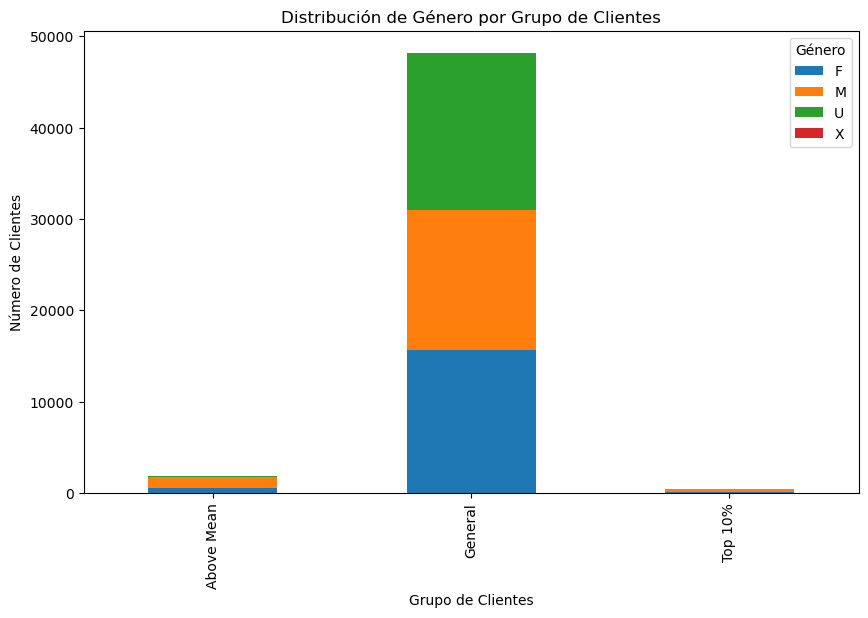

In [116]:
crosstab_group_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de Género por Grupo de Clientes')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Número de Clientes')
plt.legend(title='Género')
plt.show()

- Crosstab de group vs. tenure_years -> ¿Los clientes con mayor antigüedad (por ejemplo, más de 20 años) tienden a estar más representados en el Top 10%?

In [113]:
# Clasificar tenure_years en categorías
df_final['tenure_category'] = pd.cut(df_final['tenure_years'], bins=[0, 5, 10, 20, 50], labels=['0-5', '6-10', '11-20', '21+'])

In [114]:
crosstab_group_tenure = pd.crosstab(df_final['group'], df_final['tenure_category'])
crosstab_group_tenure

tenure_category,0-5,6-10,11-20,21+
group,,,,
Above Mean,0,0,1027,848
General,8729,15975,17792,5683
Top 10%,0,0,0,423


- Heatmap de group vs. tenure_years

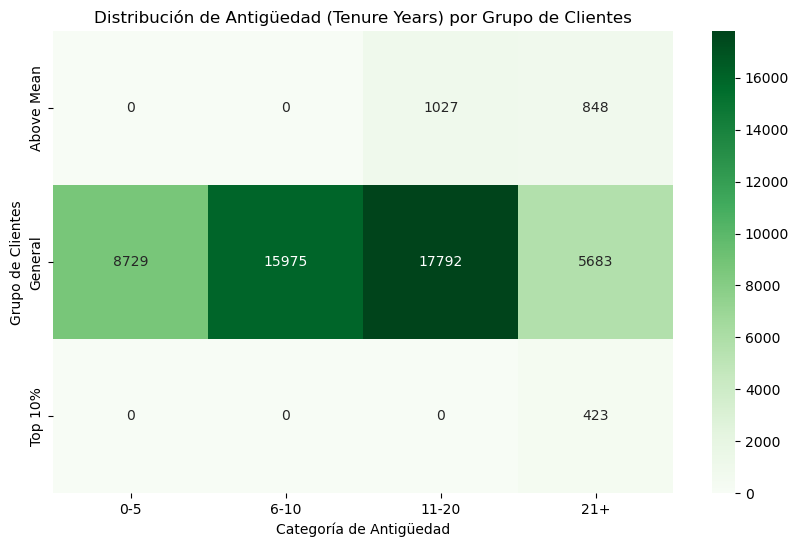

In [117]:
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_group_tenure, annot=True, cmap='Greens', fmt='d')
plt.title('Distribución de Antigüedad (Tenure Years) por Grupo de Clientes')
plt.xlabel('Categoría de Antigüedad')
plt.ylabel('Grupo de Clientes')
plt.show()

- Skewness: Mide la asimetría de la distribución de datos. Indica si los datos están sesgados hacia la derecha (skewness positiva) o hacia la izquierda (skewness negativa).
    - Positivo: Indica que la cola derecha es más larga, con una mayor concentración de valores en el lado izquierdo.
    - Negativo: Indica que la cola izquierda es más larga, con una mayor concentración de valores en el lado derecho.
    - Cerca de 0: Indica una distribución aproximadamente simétrica.

- Kurtosis: Mide la "apuntalamiento" de la distribución, es decir, cuán concentrados están los valores en los extremos de la distribución. Una kurtosis alta indica una distribución con colas largas (muchos valores extremos).
    - Mayor que 3: Indica que la distribución tiene colas más pesadas o extremas que una distribución normal.
    - Menor que 3: Indica una distribución más plana con colas menos extremas.
    - Igual a 3: Es lo esperado para una distribución normal.

- Skewness y kurtosis para balance

In [121]:
balance_skewness = skew(df_final['balance'])
balance_kurtosis = kurtosis(df_final['balance'])

print(f"Skewness de Balance: {balance_skewness}")
print(f"Kurtosis de Balance: {balance_kurtosis}")

Skewness de Balance: 11.473735597799463
Kurtosis de Balance: 294.08323027965804


- Skewness y kurtosis para tenure_years

In [122]:
tenure_skewness = skew(df_final['tenure_years'])
tenure_kurtosis = kurtosis(df_final['tenure_years'])

print(f"Skewness de Tenure Years: {tenure_skewness}")
print(f"Kurtosis de Tenure Years: {tenure_kurtosis}")

Skewness de Tenure Years: 1.0317572387170437
Kurtosis de Tenure Years: 1.0176829517477666


- Skewness y kurtosis para activity

In [123]:
activity_skewness = skew(df_final['activity'])
activity_kurtosis = kurtosis(df_final['activity'])

print(f"Skewness de Activity: {activity_skewness}")
print(f"Kurtosis de Activity: {activity_kurtosis}")

Skewness de Activity: 0.041087214888499965
Kurtosis de Activity: -1.4340583081769527


- Histogramas con curvas de densidad: ver si la distribución está sesgada (asimetría) y si tiene colas largas o cortas (curtosis).

- Para balance

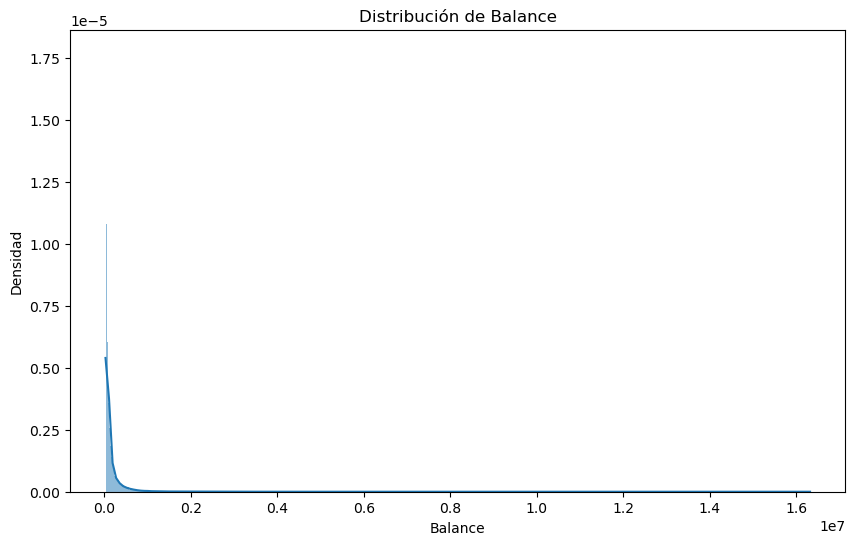

In [124]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['balance'], kde=True, stat="density", linewidth=0)
plt.title('Distribución de Balance')
plt.xlabel('Balance')
plt.ylabel('Densidad')
plt.show()

-  Para tenure_years

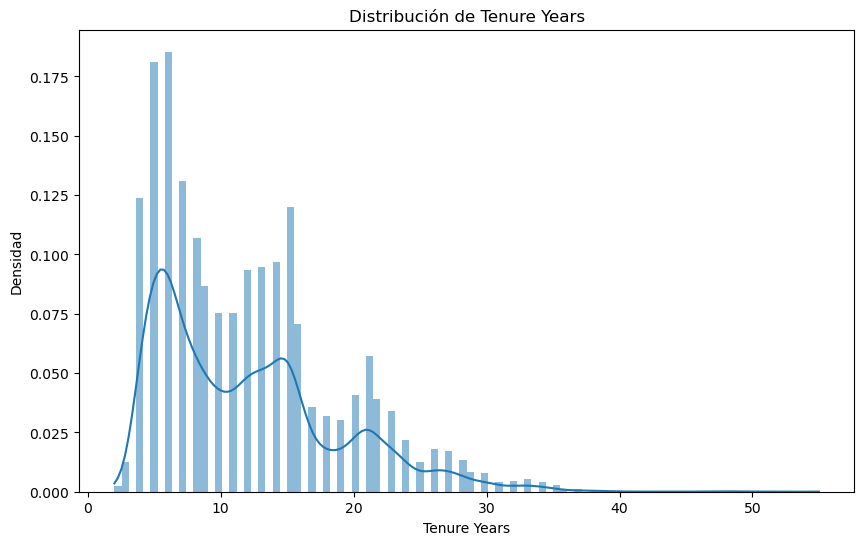

In [125]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['tenure_years'], kde=True, stat="density", linewidth=0)
plt.title('Distribución de Tenure Years')
plt.xlabel('Tenure Years')
plt.ylabel('Densidad')
plt.show()

- Para activity

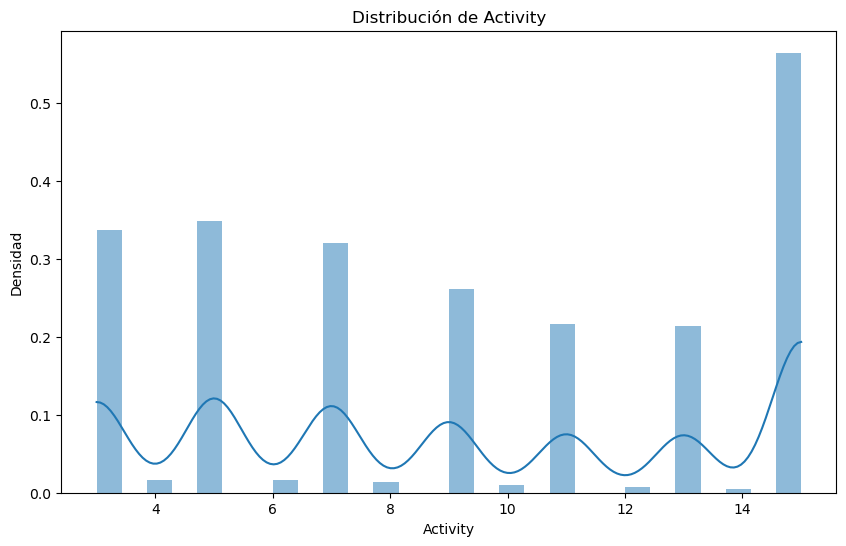

In [126]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['activity'], kde=True, stat="density", linewidth=0)
plt.title('Distribución de Activity')
plt.xlabel('Activity')
plt.ylabel('Densidad')
plt.show()

- Q-Q Plots (Quantile-Quantile Plots)
    - Comparan la distribución de nuestros datos con una distribución normal. Si los puntos se desvían significativamente de la línea recta, esto indica skewness o kurtosis.

- Para balance

<Figure size 1000x600 with 0 Axes>

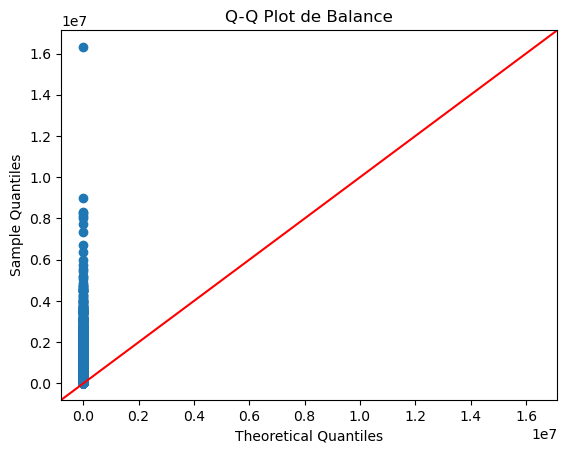

In [129]:
plt.figure(figsize=(10, 6))
sm.qqplot(df_final['balance'], line ='45')
plt.title('Q-Q Plot de Balance')
plt.show()

- Para tenure_years

<Figure size 1000x600 with 0 Axes>

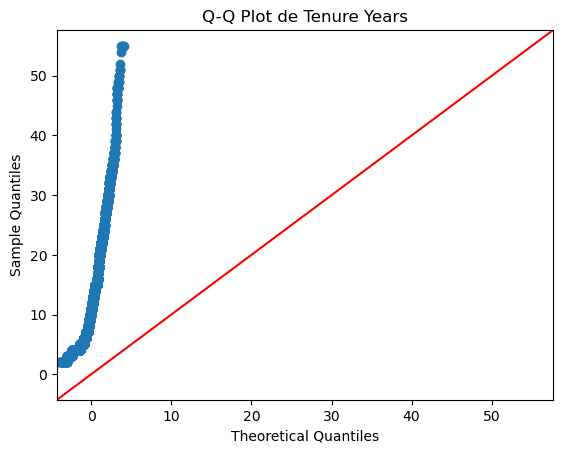

In [130]:
plt.figure(figsize=(10, 6))
sm.qqplot(df_final['tenure_years'], line ='45')
plt.title('Q-Q Plot de Tenure Years')
plt.show()

- Para activity

<Figure size 1000x600 with 0 Axes>

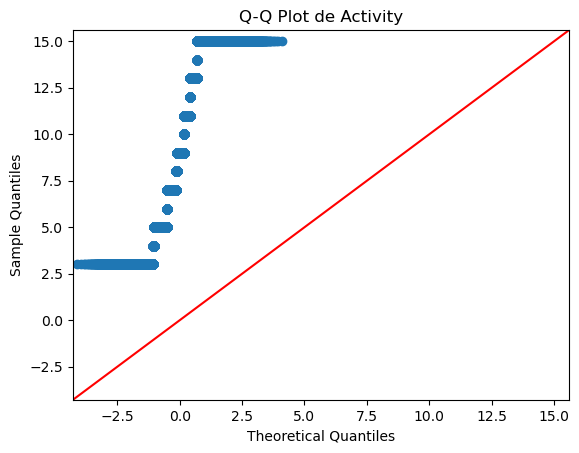

In [131]:
plt.figure(figsize=(10, 6))
sm.qqplot(df_final['activity'], line ='45')
plt.title('Q-Q Plot de Activity')
plt.show()

- Boxplots
    - Ver la skewness visualmente a través de la distribución de los datos en cuartiles, y también para identificar posibles outliers (que pueden contribuir a una alta kurtosis).
    - Datos sesgados (si la mediana no está centrada) y si hay outliers que podrían estar afectando la curtosis.

- Para balance

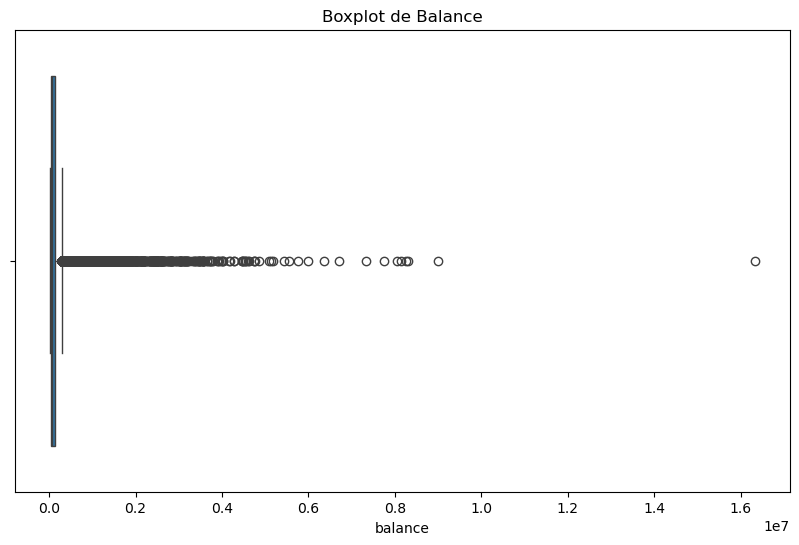

In [132]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_final['balance'])
plt.title('Boxplot de Balance')
plt.show()

- Para tenure_years

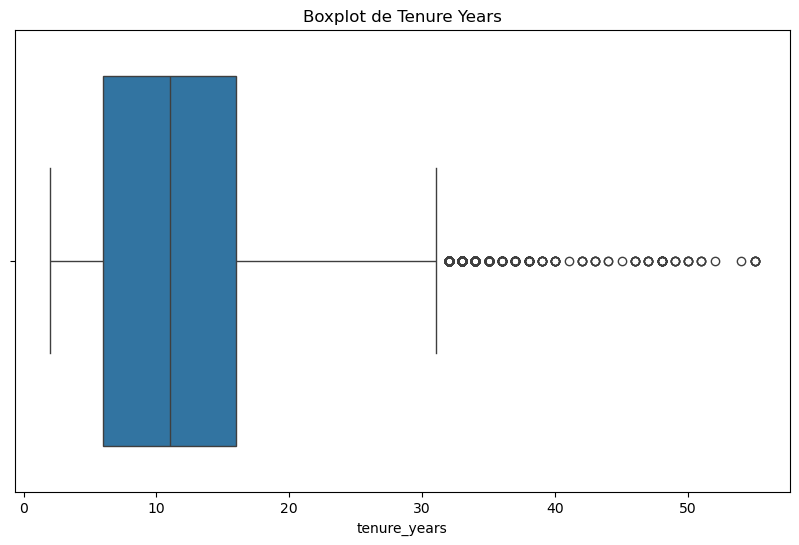

In [133]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_final['tenure_years'])
plt.title('Boxplot de Tenure Years')
plt.show()

- Para activity

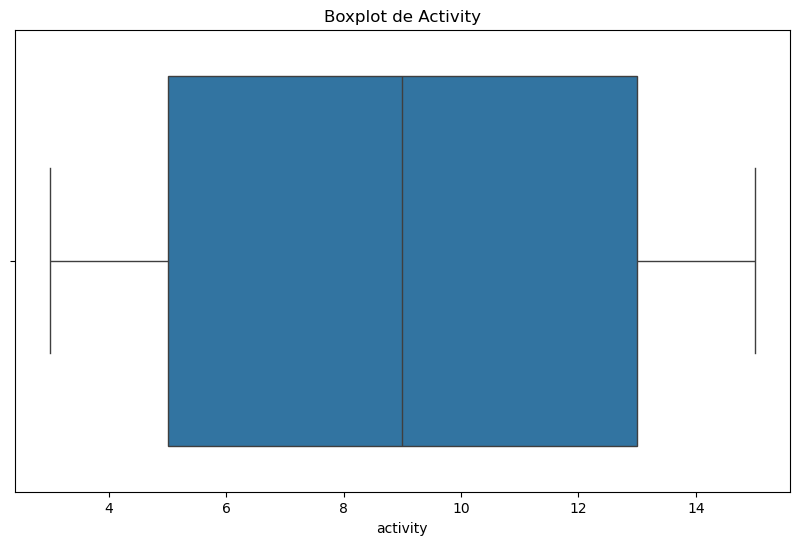

In [134]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_final['activity'])
plt.title('Boxplot de Activity')
plt.show()

- KDE Plots (Kernel Density Estimation)
    - Muestra la estimación de la densidad de probabilidad de una variable. Es especialmente útil para visualizar la skewness.
    - Forma general de la distribución, incluidas las colas largas.

- Para balance

C:\Users\usr\AppData\Local\Temp\ipykernel_10632\3334209554.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final['balance'], shade=True)


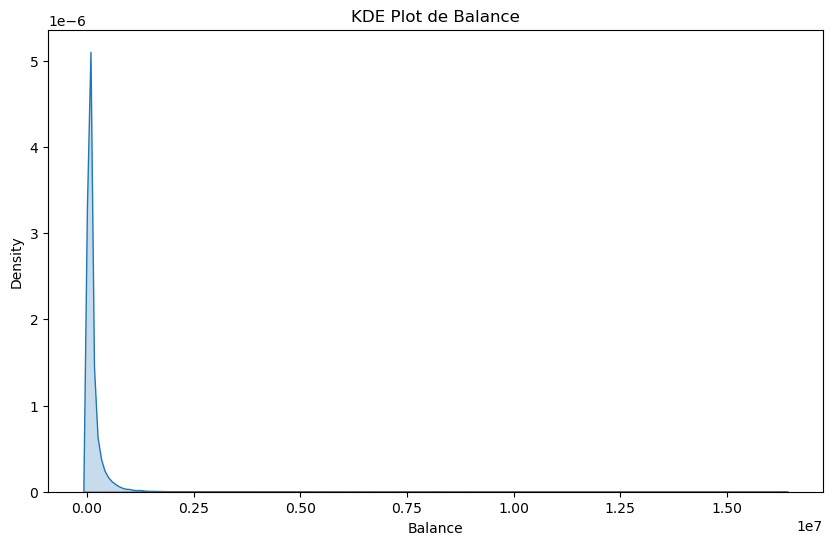

In [135]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_final['balance'], shade=True)
plt.title('KDE Plot de Balance')
plt.xlabel('Balance')
plt.show()

- Para tenure_years

C:\Users\usr\AppData\Local\Temp\ipykernel_10632\1409489100.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final['tenure_years'], shade=True)


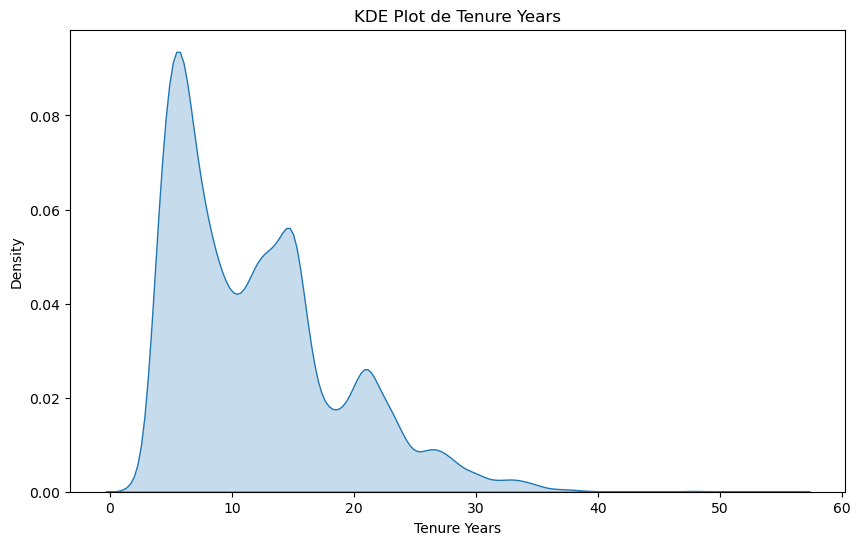

In [136]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_final['tenure_years'], shade=True)
plt.title('KDE Plot de Tenure Years')
plt.xlabel('Tenure Years')
plt.show()

- Para activity

C:\Users\usr\AppData\Local\Temp\ipykernel_10632\2726040404.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final['activity'], shade=True)


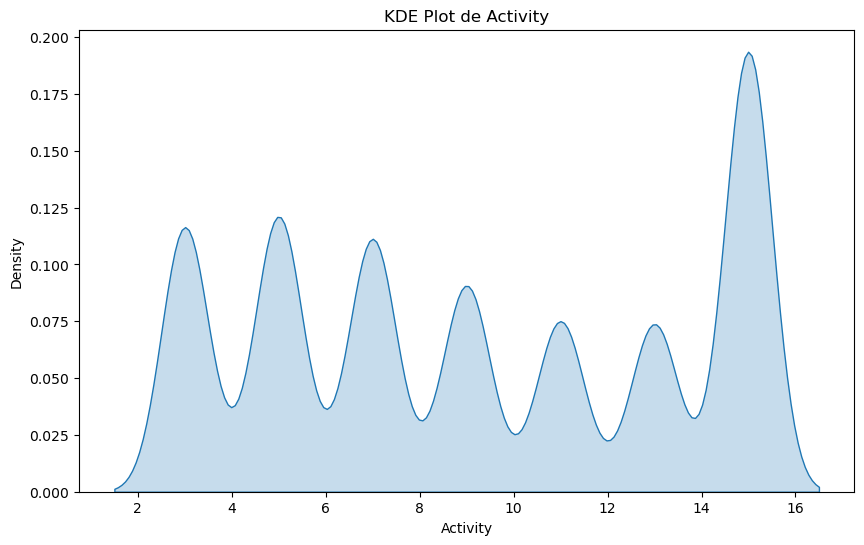

In [137]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_final['activity'], shade=True)
plt.title('KDE Plot de Activity')
plt.xlabel('Activity')
plt.show()